In [21]:
import pytesseract
from pytesseract import Output
import re
import glob
#from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Função que lê imagens, aplica image_to_data e retorna as keys

In [22]:
def data_keys(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    return d

## Função para extrair datas

In [23]:
def get_datas(img, d):
    date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$' # expressão regular para datas
    data_nasc, data_val, data_ph = 0, 0, 0
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40 and int(d['left'][i]) > 80 and int(d['top'][i]) > 80:
            print(d['text'][i])
            if re.match(date_pattern, d['text'][i]):
                #print(d['text'][i])
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                if int(d['top'][i]) >= 150 and int(d['top'][i]) <= 250:
                    data_nasc = d['text'][i]
                elif int(d['left'][i]) >= 290 and int(d['left'][i]) <= 400:
                    data_val = d['text'][i]
                elif int(d['left'][i]) >= 400 and int(d['left'][i]) <= 600:
                    data_ph = d['text'][i]
    plt.imshow(img)
    plt.show()
    
    return data_nasc, data_val, data_ph

## Função para extrair CPF

In [24]:
def get_cpf(img, d):
    #cpf_pattern = '[0-9]{3}\.?[0-9]{3}\.?[0-9]{3}\-?[0-9]{2}'

    cpf_expr = re.compile('\d{3}\.\d{3}\.\d{3}\-\d{2}')
    #cpf_expr1 = re.compile('\d{3}\.\d{3}')
    #cpf_expr2 = re.compile('\d{3}\?\d{2}')                     

    cpf = 0
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40:
            if re.match(cpf_expr, d['text'][i]):
                print(d['text'][i])
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cpf = d['text'][i]
                
    plt.imshow(img)
    plt.show()
    
    return cpf

 
mug
DIEGO
Dz
oLxVEmA
PAIVA
—wcwmulomumw
3735035
5535
an
_IIJACID
cross
ANTONIO
Pm
SILVA
RDSMEELA
SALES
DE
 
um:
 
 
ﬁlfL}
 
 
 
I.
mun
m
 
_us
muwcwmo
I31/05/19951
OLIVEIRR



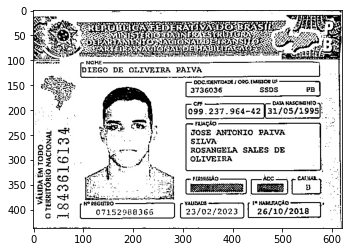

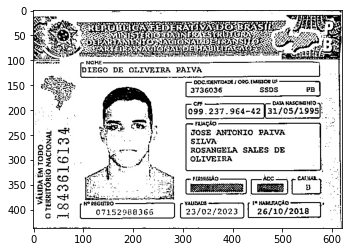

CPF:  0
Data de nascimento:  0
Data de validade:  0
Data da 1° habilitação:  0
 
 
 
 
FAMELA
DE
OLIVEIEA
SMAIO
  
..
0&me
4258795
—noc4wnwalmamsanu;
 
mama
—w
094.267
334—42
11/03/2000
 
_nww
CARVALHO
 
PEDRO
mam
D8
MARIA
DA
CONCEICAD
OLIVEIRA
CARVALHO
 
—'
mm
pmssﬁo
 
 
rm[
:3
 
»
VW—
07429160429
04/03/2021
 
 
rs
mun
04/03/2020


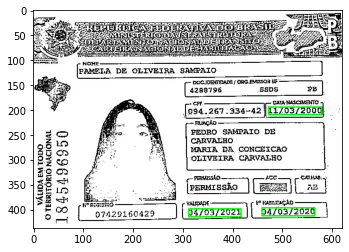

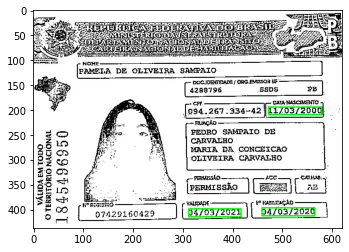

CPF:  0
Data de nascimento:  11/03/2000
Data de validade:  04/03/2021
Data da 1° habilitação:  04/03/2020
 
Gusmvo
DE
m
mm:
LEAD
TEImeA
Doc.
lurmqu/ara
missukl
w
suzszvsv
ssn/sp
m
mrnlmsanmm-
~
450.809.605-29
17/09/2000
«mm:
ADEMI'R
LEAK)
TEIXEIRA
 
 
     
  
KILDA
MERCELA
DE
AND“
'
DE
HERO
‘I‘EIXEIFA
‘
-
man:
m:
arms,
_
‘
‘
PERMISSAO
m
a
——
VALHMDE
:IIMMUTAUﬁ—I
04/09/2020
06/05/2019
 
 
 



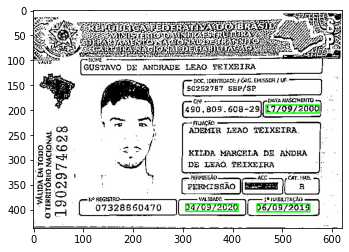

450.809.605-29


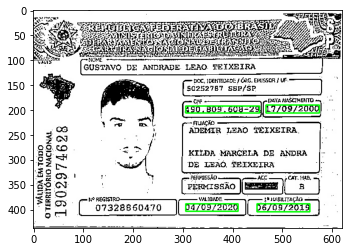

CPF:  450.809.605-29
Data de nascimento:  17/09/2000
Data de validade:  04/09/2020
Data da 1° habilitação:  06/05/2019
 
Nuns
’
GABRIELA
ROCHA
LUCENA
szs
 
._
m:
momma:
I
emmmnu
ur
3433404
55?
[=5
 
 
—ch-———
081.527.07d~73
 
mu
momma
o
9/
11
/
1
9
91
 
 
  
 
FERNANDO
ANTONIO
FERREIRA
LDPES
MARIA
HELENA
ROCHA
LUCENA
LOPES
 
 
 
 
  
 
 
 
 
 
 
nmmo
Acc
mm
,
Wm—H
E
wwzsumo
vAunAnE
mmmn
[
05173328618
”02/06/2021
I
31/03/2011
 


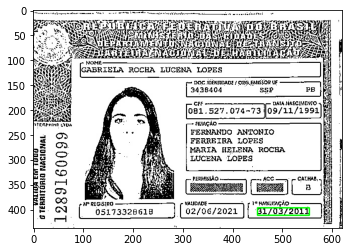

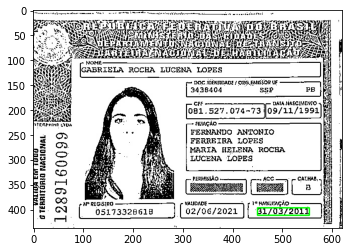

CPF:  0
Data de nascimento:  0
Data de validade:  0
Data da 1° habilitação:  31/03/2011
'Nune———-——
‘
DANIELE:
LACERDA
DE
mum
—noc.msunmnsmn=mssonur——
,
3613310
 
_
gm
msaMauo
 
09L654.1sd—79
PB
 
 
31/03/1990
,—
Hulda
ammo
mcimnA
 
FRANCISCA
RODRIGUES
DE:
Annual:
LACERDA
 
 
Fsmuun
 
 
 
 
 
 
 
 
 
V?”
 
 
I-Immuo
13/05/2015
”“1
[05/03/2025
65321297
 
.J,



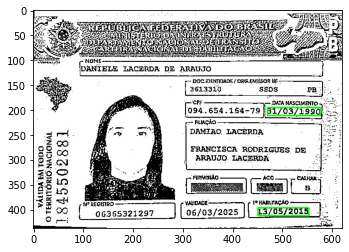

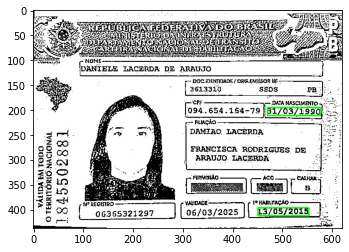

CPF:  0
Data de nascimento:  31/03/1990
Data de validade:  0
Data da 1° habilitação:  13/05/2015
  
 
DIEGO
DE.
DLIVEIRA
PAIVA
  
366
w-
moo
07152900
 
—wcwummrolalmw
3735036
5535
as
—ur
mummmo
099.237.965-42
I31/05/19951
 
 
 
JOSE
ANTONIO
PAIVR
SILVA
RDSRNEELA
SALES
DE
OLIVEIRR
.PUIMBSAD
ABC
wm
mlf
a_l
 
 
 
 
 
 
vwm
x-uuuuun
23/02/2023
26/10/2018


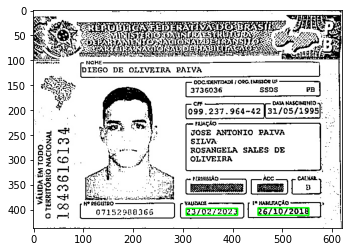

099.237.965-42


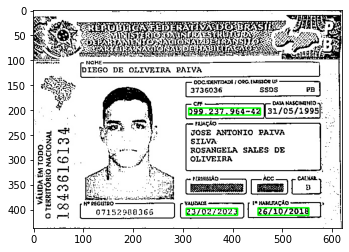

CPF:  099.237.965-42
Data de nascimento:  0
Data de validade:  23/02/2023
Data da 1° habilitação:  26/10/2018
 
mm:
'
cmos
ANDRE
cram:
m:
MELO
\
.
1
v
v
N‘IEGWO
mm:
u-muuuao
03988591705
28/08/2024
06/12/2006
—
noaniNvm-ni
I
ommmu
Ur
23304
57
sap
PE
 
 
 
—nml;Ao
ANTONIO
CARLOS
FERREIRA
DE
MELO
ANDREA
mm.
CIRNE
DE
MELO
 
.—
pzumsuxo
._
m:
mun.
 
 
WM
 
 
 
-cn
mumiclwmo
073.
962.
664-05
 
‘
 
;


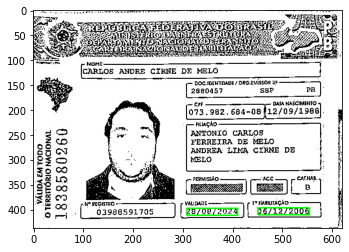

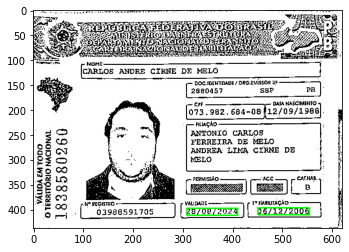

CPF:  0
Data de nascimento:  0
Data de validade:  28/08/2024
Data da 1° habilitação:  06/12/2006


In [25]:
imgs = glob.glob("../processadas/*jpg")

for c in imgs:
    img = cv2.imread(c)
    d = data_keys(img)
    data_nasc, data_val, data_ph = get_datas(img, d)
    cpf = get_cpf(img, d)
    print("CPF: ", cpf)
    print("Data de nascimento: ", data_nasc)
    print("Data de validade: ", data_val)
    print("Data da 1° habilitação: ", data_ph)

In [26]:
#cpf = get_cpf(img, d)
#print("CPF: ", cpf)

Próximos passos:

- melhorar segmentação das imagens, a leitura está péssima

-validar o cpf
https://community.alteryx.com/t5/Casos-de-uso-Portugues/Validacao-de-CPF-com-digito-verificador/ta-p/437296

OBS.: o regex cpf_pattern está reconhecendo o número de registro e não o cpf